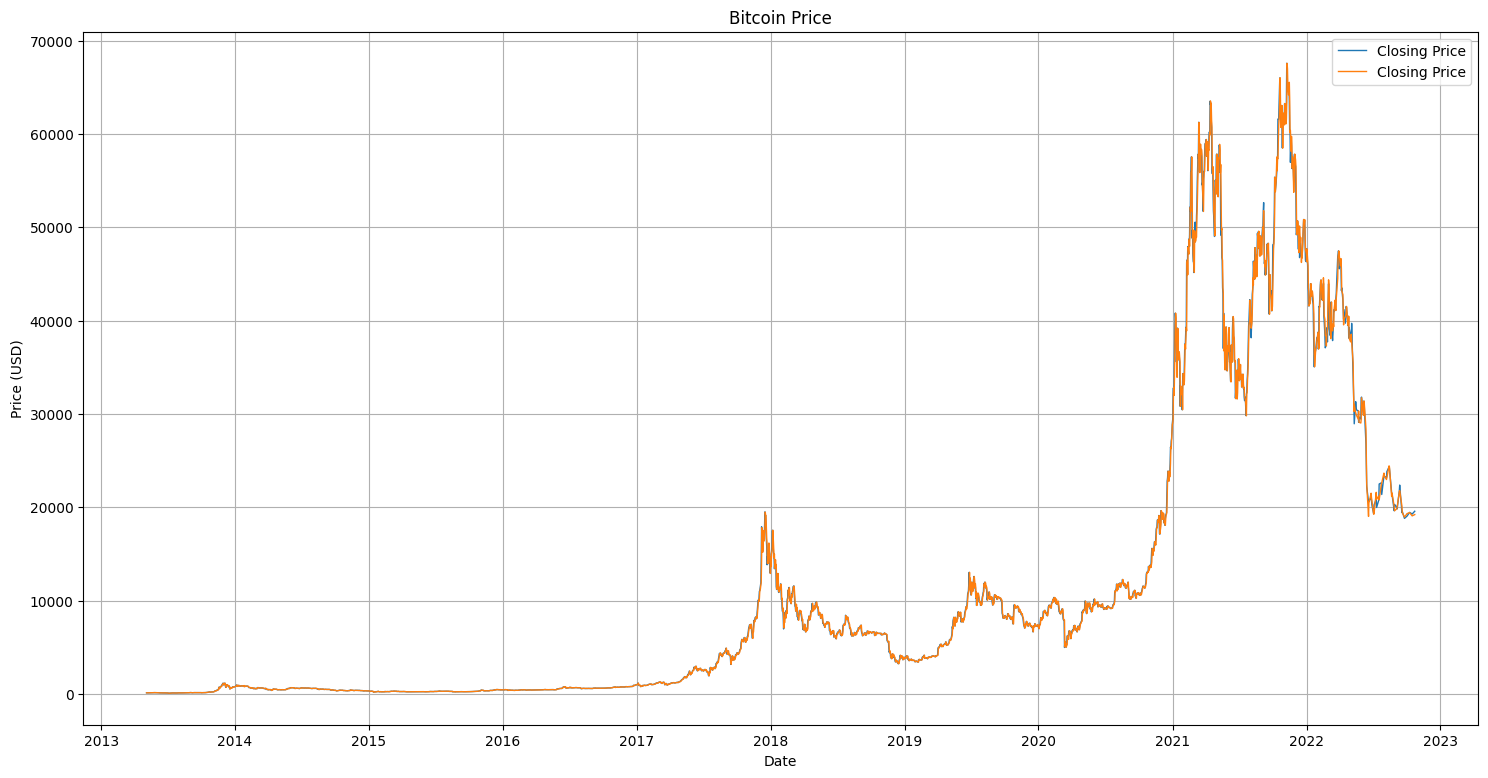

/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_55382/36179652.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df['daily_return'] = bitcoin_df['close'].pct_change()
/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_55382/36179652.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin_df['volatility_3d'] = bitcoin_df['daily_return'].rolling(window=3).std()


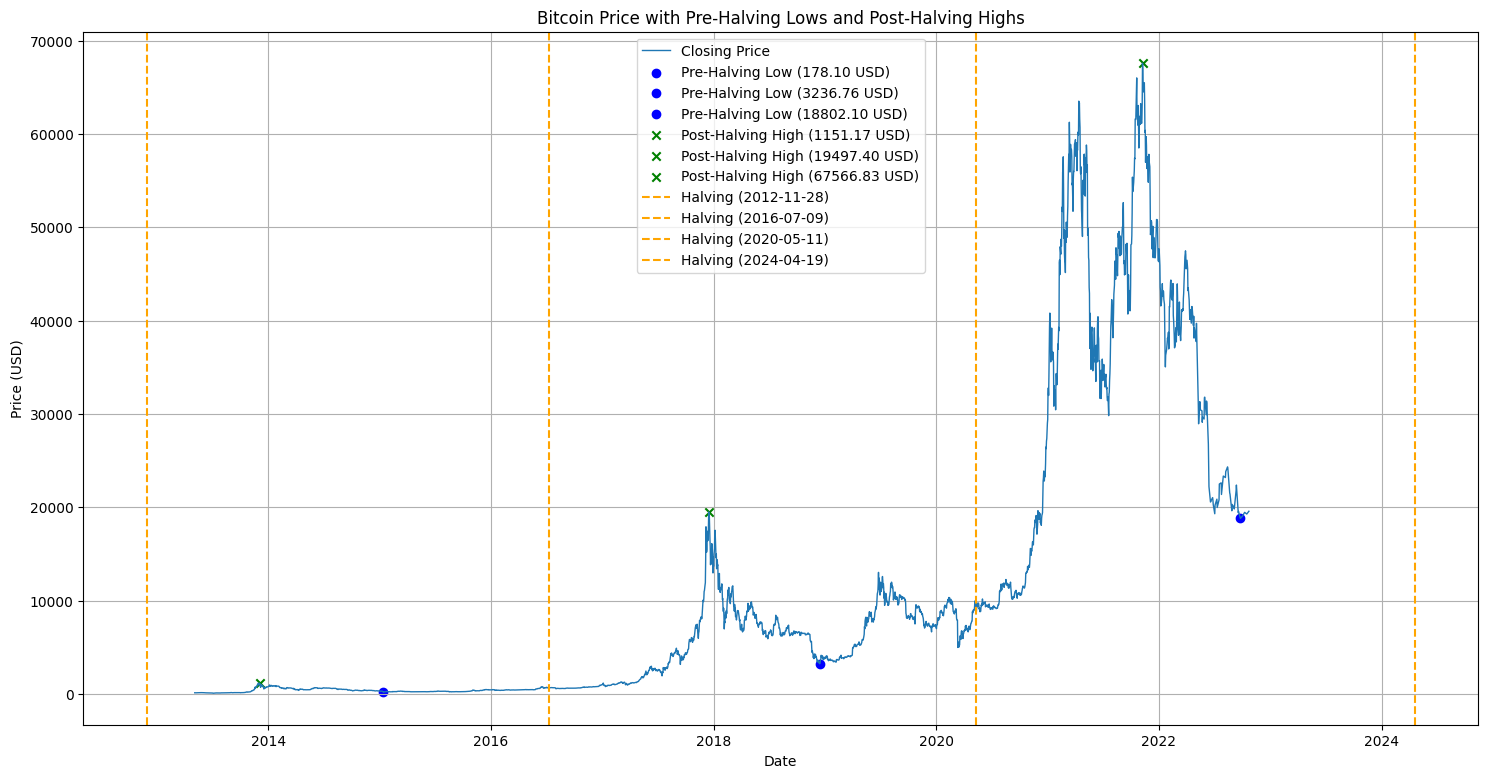

/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_55382/36179652.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_cut['adjusted_important'] = news_df_cut['important'] + 1
/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_55382/36179652.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_cut['impact'] = (news_df_cut['positive'] - news_df_cut['negative']) * news_df_cut['adjusted_important']
/var/folders/pn/sv2_pvns5zz340mv_14h10980000gp/T/ipykernel_55382/36179652.py:16

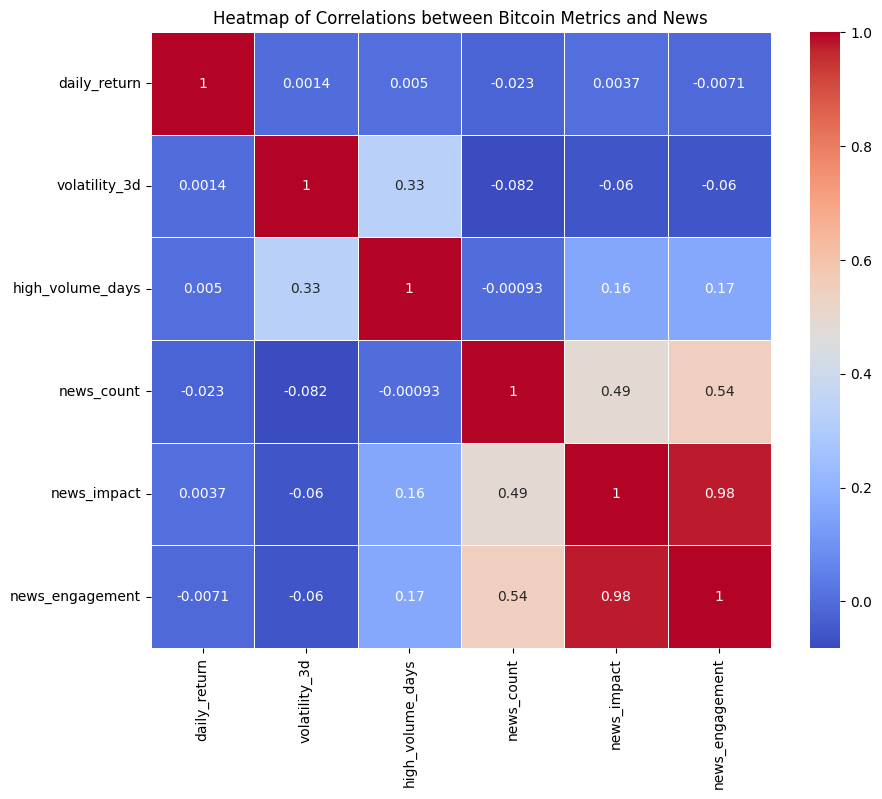

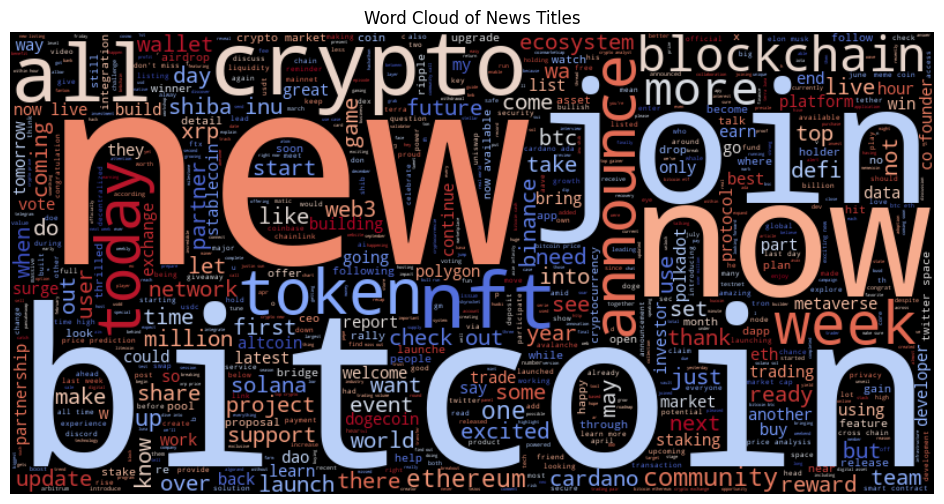

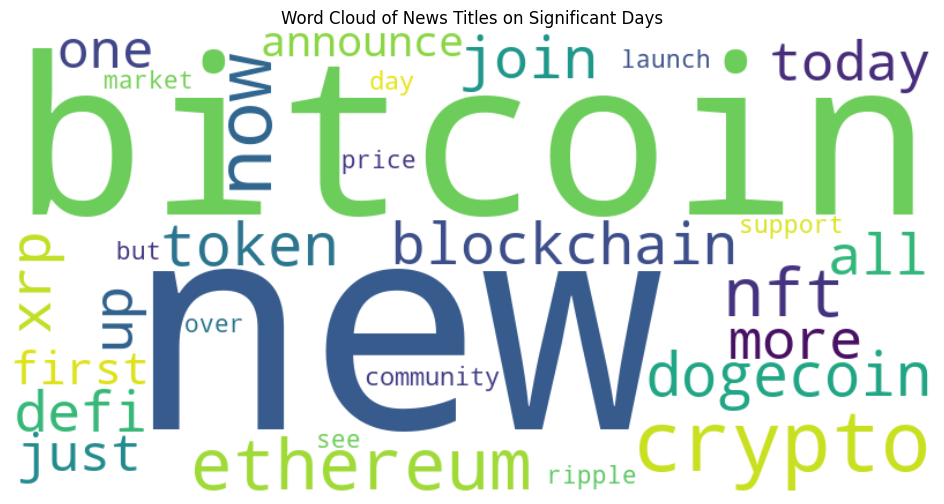

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Carica i dataset reali
prices_df = pd.read_csv('dataset.csv')
news_df = pd.read_csv('cryptopanic_news.csv')

# -------------------------------
# Fix the 'date' column in prices_df and news_df
# -------------------------------

# Convert 'date' column to datetime format with error handling
prices_df['date'] = pd.to_datetime(prices_df['date'], errors='coerce')

# Drop any rows with invalid dates
prices_df = prices_df.dropna(subset=['date'])

# Set 'date' as the index and sort by date
prices_df = prices_df.set_index('date').sort_index()


# Convert 'date' column to datetime and handle errors
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Format the 'date' column to keep only the date part (YYYY-MM-DD)
news_df['date'] = news_df['date'].dt.date

# Set 'date' as the index and sort by date
news_df = news_df.set_index('date').sort_index()

news_df.index = pd.to_datetime(news_df.index)

# Filter the prices dataset for Bitcoin only
bitcoin_df = prices_df[prices_df['crypto_name'] == 'Bitcoin']

# -------------------------------
# Step 2: Plot Bitcoin Prices
# -------------------------------

# Plot Bitcoin closing prices
plt.figure(figsize=(18, 9))
plt.plot(bitcoin_df.index, bitcoin_df['close'], bitcoin_df['open'], label='Closing Price', linewidth=1)
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# Step 3: Calculate Metrics
# -------------------------------

# Calculate daily returns
bitcoin_df['daily_return'] = bitcoin_df['close'].pct_change()

# Calculate 3-day volatility
bitcoin_df['volatility_3d'] = bitcoin_df['daily_return'].rolling(window=3).std()

# Identify high volatility (above the 95th percentile)
volatility_threshold = bitcoin_df['volatility_3d'].quantile(0.95)
high_volatility = bitcoin_df[bitcoin_df['volatility_3d'] > volatility_threshold]

# Identify high volume days (above the 95th percentile)
volume_threshold = bitcoin_df['volume'].quantile(0.95)
high_volume_days = bitcoin_df[bitcoin_df['volume'] > volume_threshold]

# Identify significant price changes (greater than 15%)
significant_changes = bitcoin_df[bitcoin_df['daily_return'].abs() > 0.15]
"""
# Add price direction (positive or negative)
bitcoin_df['direction'] = bitcoin_df['daily_return'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
"""
# -------------------------------
# Step 4: Halving Analysis
# -------------------------------

# Bitcoin halving dates
halving_dates = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-19')  # Estimated next halving
]

# Find the lowest price within 3 years before each halving
pre_halving_lows = {}
for halving_date in halving_dates:
    start_date = halving_date - pd.DateOffset(years=2)
    valid_data = bitcoin_df[start_date:halving_date]
    if not valid_data.empty:
        pre_halving_low = valid_data['close'].idxmin()
        pre_halving_lows[halving_date] = pre_halving_low

# Find the highest price within 3 years after each halving
post_halving_highs = {}
for halving_date in halving_dates:
    end_date = halving_date + pd.DateOffset(years=2)
    valid_data = bitcoin_df[halving_date:end_date]
    if not valid_data.empty:
        post_halving_high = valid_data['close'].idxmax()
        post_halving_highs[halving_date] = post_halving_high

# -------------------------------
# Step 5: Plot with Halvings, Minima, and Maxima
# -------------------------------

# Plot Bitcoin prices with pre-halving lows and post-halving highs
plt.figure(figsize=(18, 9))
plt.plot(bitcoin_df.index, bitcoin_df['close'], label='Closing Price', linewidth=1)

# Mark pre-halving lows
for halving, low_date in pre_halving_lows.items():
    price = bitcoin_df['close'].loc[low_date]
    plt.scatter(low_date, price, color='blue', marker='o', label=f'Pre-Halving Low ({price:.2f} USD)')

# Mark post-halving highs
for halving, high_date in post_halving_highs.items():
    price = bitcoin_df['close'].loc[high_date]
    plt.scatter(high_date, price, color='green', marker='x', label=f'Post-Halving High ({price:.2f} USD)')

# Mark halving dates
for halving in halving_dates:
    plt.axvline(halving, color='orange', linestyle='--', label=f'Halving ({halving.date()})')

# Plot details
plt.title('Bitcoin Price with Pre-Halving Lows and Post-Halving Highs')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


# -------------------------------
# Step 6: Align Data to Overlapping Timeframe
# -------------------------------

# Define the overlapping timeframe
start_date = pd.to_datetime('2017-09-23')
end_date = pd.to_datetime('2022-10-23')

# Filter both datasets to the overlapping timeframe
bitcoin_df_cut = bitcoin_df.loc[start_date:end_date]
news_df_cut = news_df.loc[start_date:end_date]

# -------------------------------
# Step 6: Correlation with News Data]]]
# -------------------------------

# Count the number of news articles per day
news_daily_count_cut = news_df_cut.resample('D').size().rename('news_count')

# Calculate the impact: (positive + negative) * important (weight = +1)
news_df_cut['adjusted_important'] = news_df_cut['important'] + 1
news_df_cut['impact'] = (news_df_cut['positive'] - news_df_cut['negative']) * news_df_cut['adjusted_important']
news_df_cut['engagement'] = (news_df_cut['liked'] * news_df_cut['adjusted_important']) - (news_df_cut['disliked'] * news_df_cut['adjusted_important'])

# Sum the impact per day
news_daily_impact_cut = news_df_cut['impact'].resample('D').sum()
news_daily_engagement_cut = news_df_cut['engagement'].resample('D').sum()
high_volume_days_cut = bitcoin_df_cut[bitcoin_df_cut['volume'] > volume_threshold].resample('D').sum()

# Combine Bitcoin metrics and news metrics into a single DataFrame
combined_df = pd.DataFrame({
    'daily_return': bitcoin_df_cut['daily_return'],
    'volatility_3d': bitcoin_df_cut['volatility_3d'],
    'high_volume_days': bitcoin_df_cut['volume'],
    'news_count': news_daily_count_cut,
    'news_impact': news_daily_impact_cut,
    'news_engagement': news_daily_engagement_cut
}).fillna(0)  # Fill NaN values with 0

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Bitcoin Metrics and News')
plt.show()


# -------------------------------
# Now let's filter News for Significant Days
# -------------------------------

# -------------------------------
# Identify Significant Days
# -------------------------------

# Combine all significant days into one DataFrame
significant_days = pd.concat([high_volatility, significant_changes, high_volume_days])
significant_days = significant_days.sort_index().drop_duplicates()

# Extract the dates of the significant days
significant_dates = significant_days.index.date

# Filter the news for these dates
significant_news = news_df[news_df.index.normalize().isin(pd.to_datetime(significant_dates))]

# Define the list of casual words to exclude
casual_words = [
    'the', 'a', 'in', 'per', 'rt', 'on', 'for', 'of', 'is', 'to', 'and', 'with',
    'you', 'are', 'we', 'as', 'our', 'this', 'will', 'at', 'be', 'your', 'by',
    'from', '-', 'has', 'that', 'have', '&amp;', 'can', 'it', 'an', 'about',
    'how', 'us', 'get', 'what', 'been', "we're", 'here', 'than', '', ' ', 'rly',
    '(2022-06-16)', '( 2022-06-16 )', 'S', 'did', 'amp', 'or', 'which', 'its',
    't', 'why', 'any', 'after', 'ama', 'robo-01', 'these', 'i', 'hi', 'if', 'their'
]

# Concatenate all the titles into a single string
titles_text = ' '.join(news_df['title'].dropna().str.lower())

# Generate the ALL TITLES word cloud while excluding the casual words
wordcloud = WordCloud(stopwords=set(casual_words), width=800, height=400, background_color='black',colormap='coolwarm', max_words=3000).generate(titles_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Titles')
plt.show()

# Concatenate all the titles into a single string
significant_titles_text = ' '.join(significant_news['title'].dropna().str.lower())

# Generate word cloud while excluding the casual words
wordcloud = WordCloud(stopwords=set(casual_words), width=800, height=400, background_color='white',colormap='viridis', max_words=30).generate(significant_titles_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Titles on Significant Days')
plt.show()


In [17]:
combined_df

,positive,negative,important,liked,disliked,impact,engagement,close
date,,,,,,,,
2017-09-23,3,0,1,0,0,6,0,3792.399902
2017-09-24,0,0,0,0,0,0,0,3682.840088
2017-09-25,0,0,0,0,0,0,0,3926.070068
2017-09-26,0,0,0,0,0,0,0,3892.350098
2017-09-27,0,0,0,0,0,0,0,4200.669922
...,...,...,...,...,...,...,...,...
2022-09-25,33,25,23,29,18,27,33,18802.097976
2022-10-02,19,9,7,11,8,59,32,19044.107272
2022-10-09,43,24,28,43,22,56,88,19446.426194



Mean Absolute Error (MAE): 724.3372643906827
Mean Squared Error (MSE): 921306.401369274
Root Mean Squared Error (RMSE): 959.8470718657603
R^2 Score: 0.9926467305420656


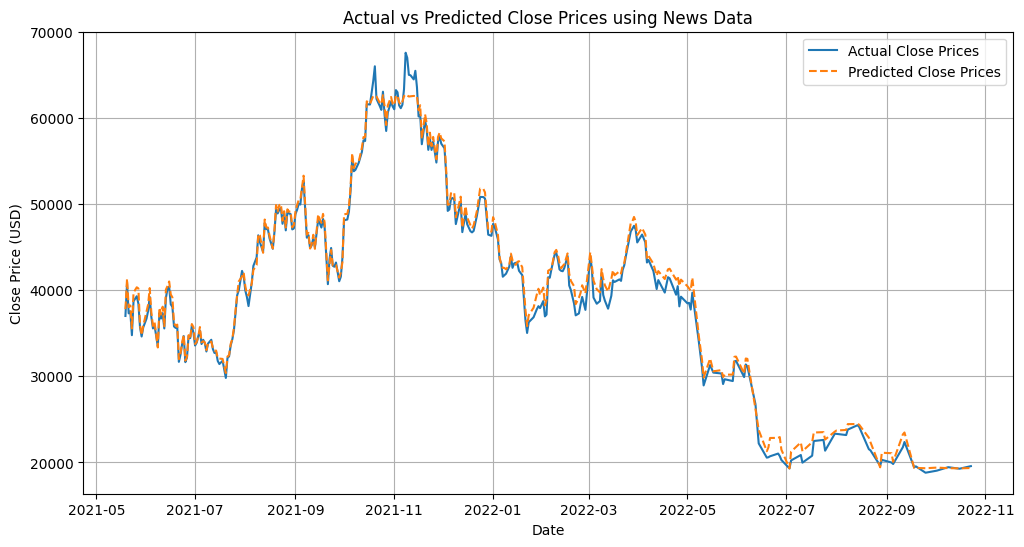

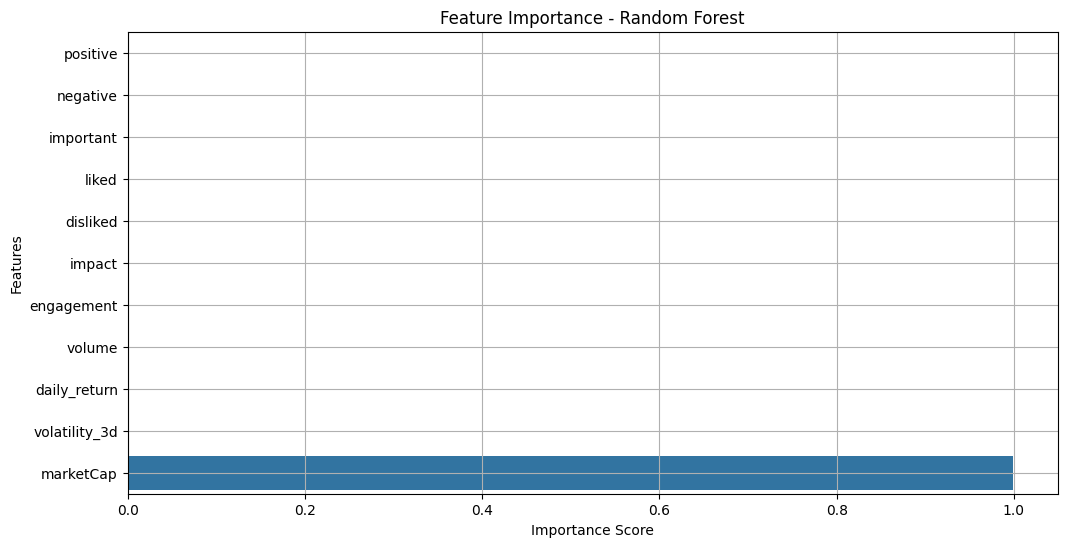

In [34]:
# Importare librerie necessarie
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Aggregare le Metriche delle News per Giorno
# -------------------------------

# Selezionare le colonne delle metriche delle news
news_features = news_df_cut[['positive', 'negative', 'important', 'liked', 'disliked', 'impact', 'engagement']]

# Aggregare le metriche delle news per giorno
news_daily_features = news_features.resample('D').sum().fillna(0)

# -------------------------------
# 2. Allineare le Date e Creare il Dataset Combinato
# -------------------------------

# Selezionare le colonne dal dataset dei prezzi di Bitcoin
bitcoin_close = bitcoin_df_cut[['close', 'volume', 'daily_return', 'volatility_3d', 'marketCap']]

# Unire le metriche delle news con i prezzi di chiusura di Bitcoin
combined_df = news_daily_features.join(bitcoin_close, how='inner')

# Rimuovere eventuali valori NaN
combined_df = combined_df.dropna()

# -------------------------------
# 3. Creare le Features (X) e il Target (y)
# -------------------------------
X = combined_df[['positive', 'negative', 'important', 'liked', 'disliked', 'impact', 'engagement',
                 'volume', 'daily_return', 'volatility_3d', 'marketCap']]
y = combined_df['close']

# -------------------------------
# 4. Separare in Train/Test (80% Train, 20% Test)
# -------------------------------

div = int(round(len(X) * 0.8))
X_train = X[:div]
y_train = y[:div]
X_test = X[div:]
y_test = y[div:]

# -------------------------------
# 5. Allenare il Modello Random Forest
# -------------------------------

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

# -------------------------------
# 6. Fare le Predizioni
# -------------------------------

y_pred = rf.predict(X_test)

# -------------------------------
# 7. Valutare il Modello
# -------------------------------

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

# -------------------------------
# 8. Visualizzare le Predizioni vs Valori Reali
# -------------------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', linewidth=1.5)
plt.plot(y_test.index, y_pred, label='Predicted Close Prices', linewidth=1.5, linestyle='--')
plt.title('Actual vs Predicted Close Prices using News Data')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 9. Visualizzare l'Importanza delle Feature
# -------------------------------

importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.show()

Best Parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 1.0}

SVR Metrics:
Mean Absolute Error (MAE): 32685.52431922115
Mean Squared Error (MSE): 1193595333.793413
Root Mean Squared Error (RMSE): 34548.449079421975
R^2 Score: -8.526502909424822


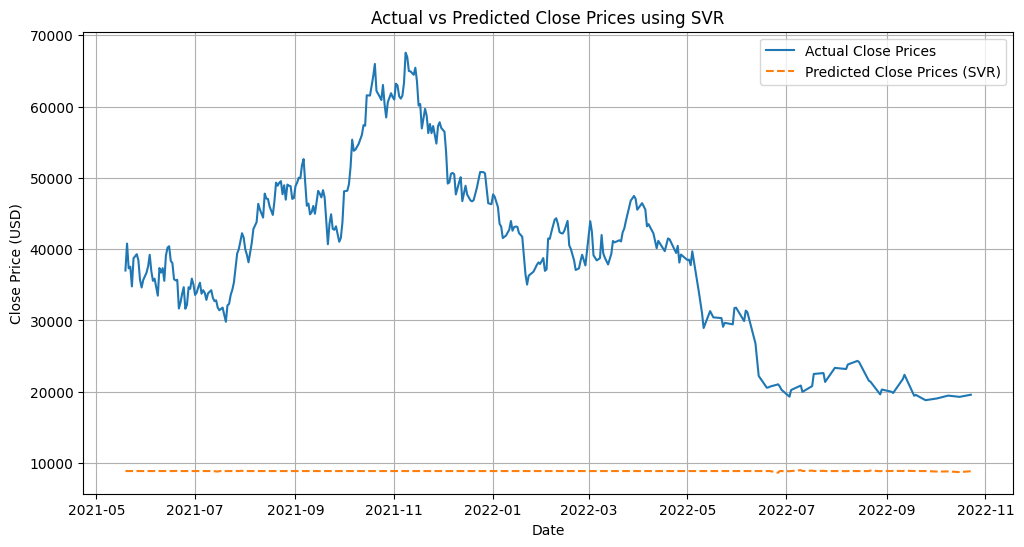

In [32]:
# Importare librerie necessarie
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Inizializza lo scaler
scaler = StandardScaler()

# Scala i dati di train e test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# -------------------------------
# 1. Allenare il Modello SVR
# -------------------------------
svr = SVR(kernel='rbf', C=100, epsilon=0.01, gamma=0.1)
svr.fit(X_train_scaled, y_train)

param_grid = {
    'C': [1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto', 1.0, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Utilizza i migliori parametri trovati
svr = grid_search.best_estimator_


# -------------------------------
# 2. Fare le Predizioni con SVR
# -------------------------------

y_pred_svr = svr.predict(X_test_scaled)

# -------------------------------
# 3. Valutare il Modello SVR
# -------------------------------

mae = mean_absolute_error(y_test, y_pred_svr)
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_svr)

print("\nSVR Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

# -------------------------------
# 4. Visualizzare le Predizioni vs Valori Reali (SVR)
# -------------------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', linewidth=1.5)
plt.plot(y_test.index, y_pred_svr, label='Predicted Close Prices (SVR)', linewidth=1.5, linestyle='--')
plt.title('Actual vs Predicted Close Prices using SVR')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


Linear Regression Metrics:
Mean Absolute Error (MAE): 748.3139511437837
Mean Squared Error (MSE): 631615.8796278044
Root Mean Squared Error (RMSE): 794.7426499363202
R^2 Score: 0.9949588521800014


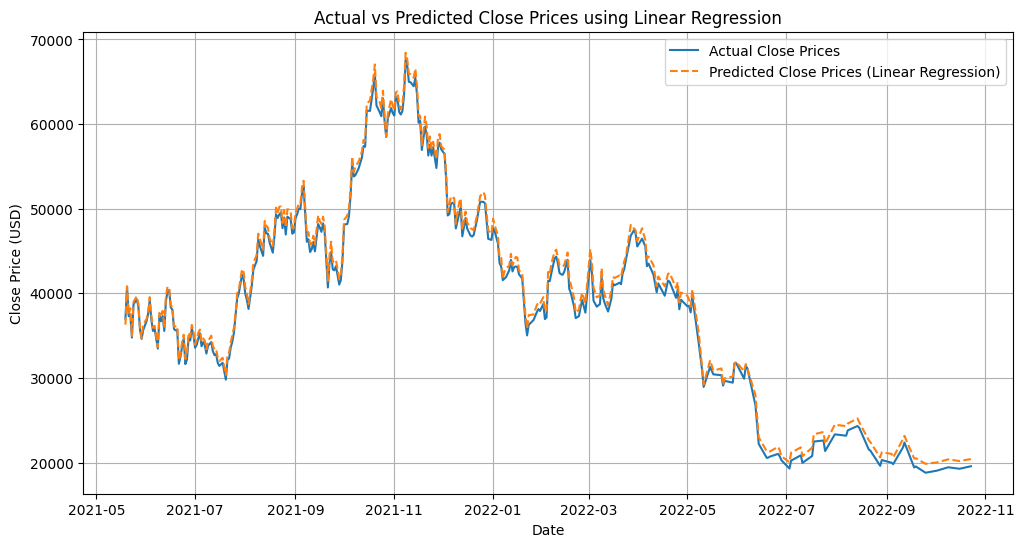

In [35]:
# Importare librerie necessarie
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 1. Allenare il Modello Linear Regression
# -------------------------------

lr = LinearRegression()
lr.fit(X_train, y_train)

# -------------------------------
# 2. Fare le Predizioni con Linear Regression
# -------------------------------

y_pred_lr = lr.predict(X_test)

# -------------------------------
# 3. Valutare il Modello Linear Regression
# -------------------------------

mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

# -------------------------------
# 4. Visualizzare le Predizioni vs Valori Reali (Linear Regression)
# -------------------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Close Prices', linewidth=1.5)
plt.plot(y_test.index, y_pred_lr, label='Predicted Close Prices (Linear Regression)', linewidth=1.5, linestyle='--')
plt.title('Actual vs Predicted Close Prices using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

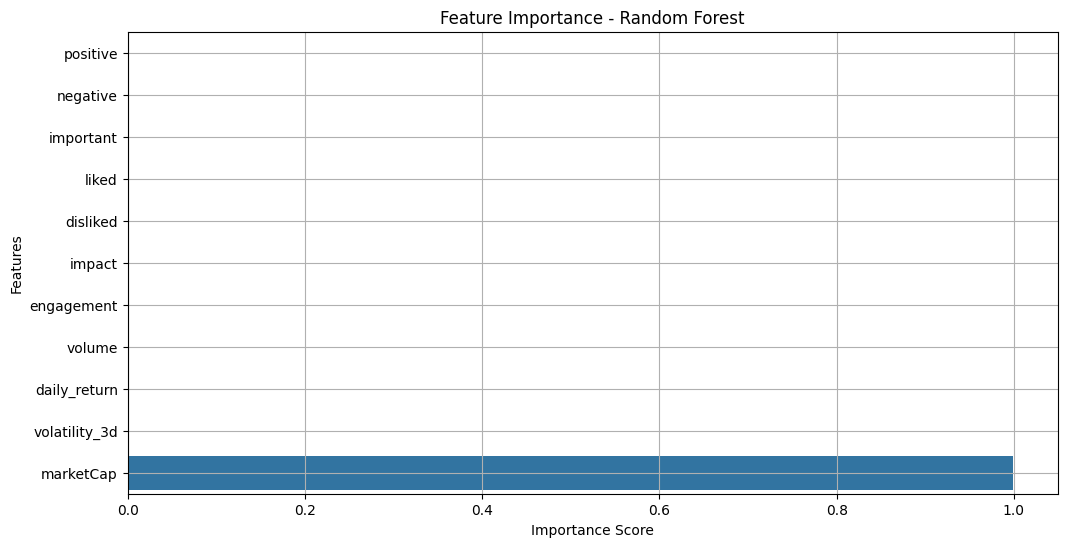

/Users/giovanna/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


ValueError: X has 11 features, but SVR is expecting 10 features as input.

In [36]:
# Importare librerie necessarie
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance

# -------------------------------
# 1. Importanza delle Features per Random Forest
# -------------------------------

# Calcolare l'importanza delle feature per Random Forest
rf_importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=rf_importances, y=feature_names)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# -------------------------------
# 2. Importanza delle Features per SVR tramite Permutazione
# -------------------------------

svr_importance = permutation_importance(svr, X_test, y_test, n_repeats=10, random_state=42)
plt.figure(figsize=(12, 6))
sns.barplot(x=svr_importance.importances_mean, y=feature_names)
plt.title('Feature Importance - SVR (Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# -------------------------------
# 3. Importanza delle Features per Linear Regression tramite Permutazione
# -------------------------------

lr_importance = permutation_importance(lr, X_test, y_test, n_repeats=10, random_state=42)
plt.figure(figsize=(12, 6))
sns.barplot(x=lr_importance.importances_mean, y=feature_names)
plt.title('Feature Importance - Linear Regression (Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# -------------------------------
# 4. Visualizzare l'Andamento delle Metriche delle News nel Tempo
# -------------------------------

plt.figure(figsize=(12, 8))
for col in ['positive', 'negative', 'important', 'liked', 'disliked', 'impact', 'engagement']:
    plt.plot(news_daily_features.index, news_daily_features[col], label=col)

plt.title('News Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Metric Values')
plt.legend()
plt.grid(True)
plt.show()